# Free-to-Play Gaming Trends — SIS Project


## Project plan

- **API:** FreeToGame API — fetch list of free-to-play games
- **Web scraping:** Microsoft Store — *Top free games*
- **Cleaning:** handle missing values, normalize names, parse dates
- **Join:** compare API titles to Wikipedia popular games (by title)
- **EDA & Visualizations:** genre distribution, platform counts, releases over time

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime


## 2) Fetch data from FreeToGame API

Attempt to get data from `https://www.freetogame.com/api/games`. 

In [12]:
api_url = "https://www.freetogame.com/api/games"

resp = requests.get(api_url, timeout=10)
games = resp.json()
print(f"Got {len(games)} games from FreeToGame API.")

Got 417 games from FreeToGame API.


### Convert API data to DataFrame and preview

In [3]:
df_api = pd.DataFrame(games)[['id','title','thumbnail','short_description','game_url','genre','platform','publisher','developer','release_date','freetogame_profile_url']]
df_api['release_date'] = pd.to_datetime(df_api['release_date'], errors='coerce')
print(f"API DataFrame created ({len(df_api)} rows)")
display(df_api.head())

API DataFrame created (417 rows)


,id,title,thumbnail,short_description,game_url,genre,platform,publisher,developer,release_date,freetogame_profile_url
0,540,Overwatch 2,https://www.freetogame.com/g/540/thumbnail.jpg,A hero-focused first-person team shooter from ...,https://www.freetogame.com/open/overwatch-2,Shooter,PC (Windows),Activision Blizzard,Blizzard Entertainment,2022-10-04,https://www.freetogame.com/overwatch-2
1,516,PUBG: BATTLEGROUNDS,https://www.freetogame.com/g/516/thumbnail.jpg,Get into the action in one of the longest runn...,https://www.freetogame.com/open/pubg,Shooter,PC (Windows),"KRAFTON, Inc.","KRAFTON, Inc.",2022-01-12,https://www.freetogame.com/pubg
2,508,Enlisted,https://www.freetogame.com/g/508/thumbnail.jpg,Get ready to command your own World War II mil...,https://www.freetogame.com/open/enlisted,Shooter,PC (Windows),Gaijin Entertainment,Darkflow Software,2021-04-08,https://www.freetogame.com/enlisted
3,604,FragPunk,https://www.freetogame.com/g/604/thumbnail.jpg,A free-to-play 5v5 hero shooter that uses card...,https://www.freetogame.com/open/fragpunk,Shooter,PC (Windows),Bad Guitar Studio,Bad Guitar Studio,2025-03-06,https://www.freetogame.com/fragpunk
4,590,Throne And Liberty,https://www.freetogame.com/g/590/thumbnail.jpg,A free-to-play multi-platorm MMORPG from NCSof...,https://www.freetogame.com/open/throne-and-lib...,MMORPG,PC (Windows),Amazon Games,NCSoft,2024-10-01,https://www.freetogame.com/throne-and-liberty


## 3) Web scraping — Microsoft

In [14]:
import requests, pandas as pd
from bs4 import BeautifulSoup

url = "https://www.microsoft.com/en-us/store/top-free/games/xbox" # 

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
    "Referer": "https://www.google.com/",
    "DNT": "1",
    "Upgrade-Insecure-Requests": "1",
    "Connection": "keep-alive"
}

r = requests.get(url, headers=headers, timeout=20)
soup = BeautifulSoup(r.text, "html.parser")

titles = []
for tag in soup.find_all("h3"):
    text = tag.get_text(strip=True)
    if text and len(text.split()) > 1 and not any(word in text.lower() for word in ["free", "install", "microsoft"]):
        titles.append(text)

df_ms = pd.DataFrame(sorted(set(titles)), columns=["title"])
print(f"Parsed {len(df_ms)} games from Microsoft Store")
display(df_ms.head(10))


Parsed 37 games from Microsoft Store


,title
0,Apex Legends™
1,Asphalt Legends
2,Call of Duty®: Modern Warfare® II - DMZ Beta
3,Call of Duty®: Modern Warfare® II Launcher
4,Call of Duty®: Modern Warfare® III Launcher
5,Call of Duty®: Warzone™
6,Delta Force
7,Destiny 2
8,Disney Speedstorm
9,Fall Guys


### Clean Microsoft table (keep Title / Notes)

In [16]:
cols = df_ms.columns.tolist()
title_col = None
for c in cols:
    if df_ms[c].dtype == object:
        title_col = c
        break
    if title_col is None:
        title_col = cols[0]
df_ms_clean = df_ms.copy()
df_ms_clean = df_ms_clean.rename(columns={title_col: 'title_raw'})
df_ms_clean['title'] = df_ms_clean['title_raw'].astype(str).str.replace(r'\[.*?\]', '', regex=True).str.strip()
df_ms_clean = df_ms_clean[['title']].dropna().drop_duplicates().reset_index(drop=True).iloc[:50]
display(df_ms_clean)


,title
0,Apex Legends™
1,Asphalt Legends
2,Call of Duty®: Modern Warfare® II - DMZ Beta
3,Call of Duty®: Modern Warfare® II Launcher
4,Call of Duty®: Modern Warfare® III Launcher
5,Call of Duty®: Warzone™
6,Delta Force
7,Destiny 2
8,Disney Speedstorm
9,Fall Guys


## 4) Match and compare API vs Microsoft titles

In [6]:
df_matches = df_ms.merge(df_api, left_on=df_ms["title"].str.lower(), right_on=df_api["title"].str.lower())
df_matches = df_matches[["title_x", "title_y"]].rename(columns={"title_x": "microsoft_title", "title_y": "api_title"})
print(f"Found {len(df_matches)} exact matches between Microsoft Store and FreeToGame API")
display(df_matches)

Found 11 exact matches between Microsoft Store and FreeToGame API


,microsoft_title,api_title
0,Delta Force,Delta Force
1,Destiny 2,Destiny 2
2,Fall Guys,Fall Guys
3,Fishing Planet,Fishing Planet
4,Genshin Impact,Genshin Impact
5,Halo Infinite,Halo Infinite
6,Marvel Rivals,Marvel Rivals
7,PUBG: BATTLEGROUNDS,PUBG: BATTLEGROUNDS
8,Splitgate 2,Splitgate 2
9,THE FINALS,The Finals


## 5) EDA & Visualizations (>=3 plots)

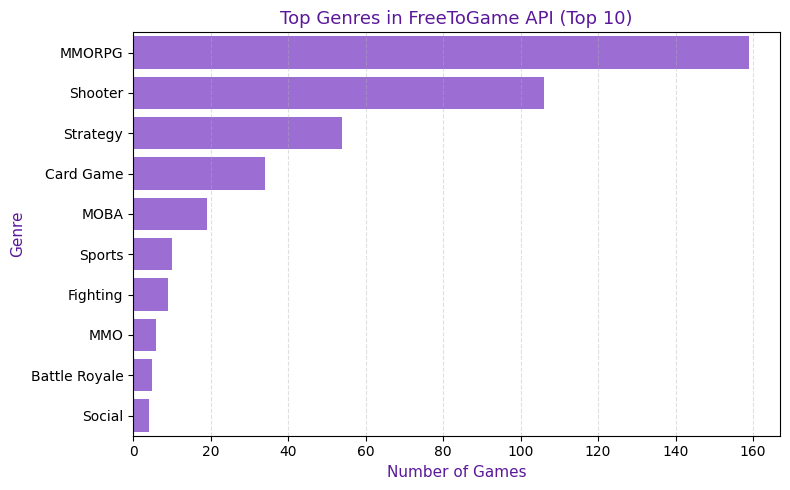

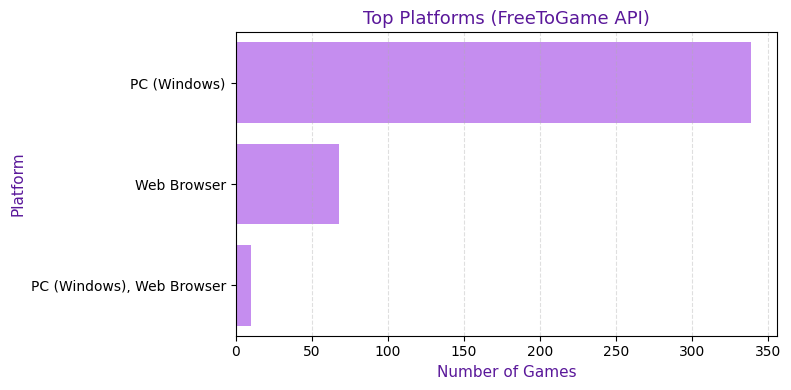

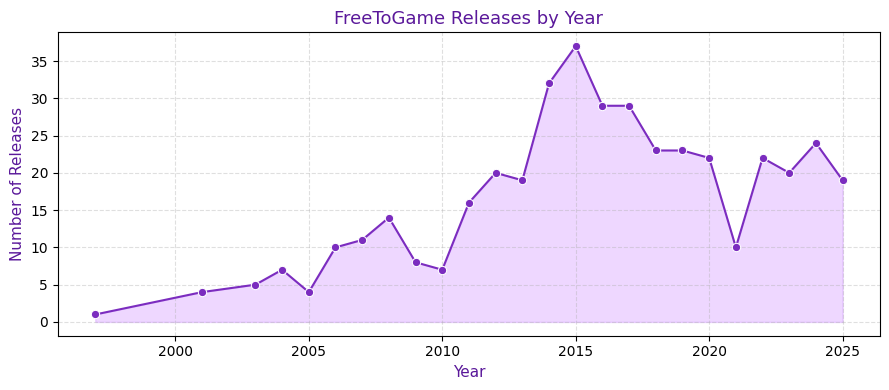

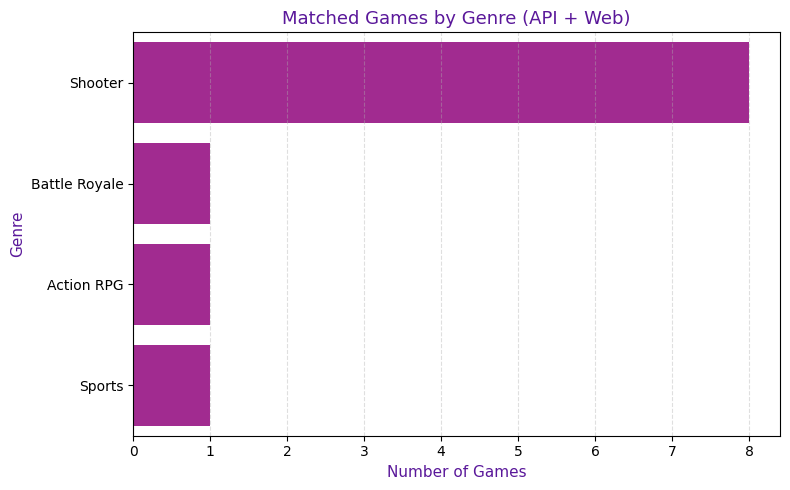

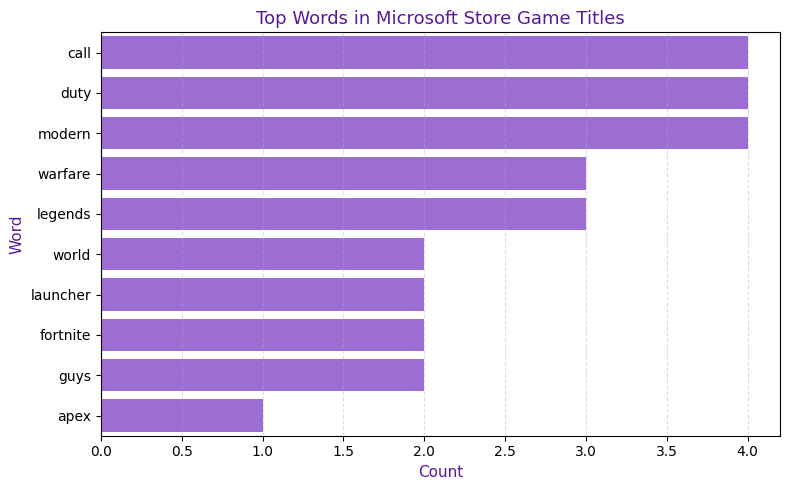

In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from collections import Counter
import re

# Genres (API)
genre_counts = df_api['genre'].fillna('Unknown').value_counts().reset_index()
genre_counts.columns = ['genre', 'count']
top_genres = genre_counts.head(10)

plt.figure(figsize=(8, 5))
sns.barplot(data=top_genres, x='count', y='genre', color='#9b5de5')
plt.title('Top Genres in FreeToGame API (Top 10)', fontsize=13, color='#5a189a')
plt.xlabel('Number of Games', fontsize=11, color='#5a189a')
plt.ylabel('Genre', fontsize=11, color='#5a189a')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Platforms (API)
platform_counts = df_api['platform'].fillna('Unknown').value_counts().reset_index()
platform_counts.columns = ['platform', 'count']

plt.figure(figsize=(8, 4))
sns.barplot(data=platform_counts.head(8), x='count', y='platform', color='#c77dff')
plt.title('Top Platforms (FreeToGame API)', fontsize=13, color='#5a189a')
plt.xlabel('Number of Games', fontsize=11, color='#5a189a')
plt.ylabel('Platform', fontsize=11, color='#5a189a')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Releases by Year (API)
df_api['year'] = pd.to_datetime(df_api['release_date'], errors='coerce').dt.year
year_counts = df_api['year'].dropna().astype(int).value_counts().sort_index().reset_index()
year_counts.columns = ['year', 'count']

plt.figure(figsize=(9, 4))
sns.lineplot(data=year_counts, x='year', y='count', color='#7b2cbf', marker='o')
plt.fill_between(year_counts['year'], year_counts['count'], color='#c77dff', alpha=0.3)
plt.title('FreeToGame Releases by Year', fontsize=13, color='#5a189a')
plt.xlabel('Year', fontsize=11, color='#5a189a')
plt.ylabel('Number of Releases', fontsize=11, color='#5a189a')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Matched Games (API + Web)
matched_titles = df_matches['api_title'].str.lower().tolist()
df_api_matched = df_api[df_api['title'].str.lower().isin(matched_titles)]
genre_matched = df_api_matched['genre'].fillna('Unknown').value_counts().reset_index().head(8)
genre_matched.columns = ['genre', 'count']

plt.figure(figsize=(8, 5))
sns.barplot(data=genre_matched, x='count', y='genre', color='#b5179e')
plt.title('Matched Games by Genre (API + Web)', fontsize=13, color='#5a189a')
plt.xlabel('Number of Games', fontsize=11, color='#5a189a')
plt.ylabel('Genre', fontsize=11, color='#5a189a')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Top Words (Web Scraping)
words = []
for title in df_ms['title']:
    title = re.sub(r'[^A-Za-z0-9 ]+', '', title)
    words.extend(title.lower().split())

word_counts = Counter(words)
stopwords = {'the','of','and','in','on','to','a','for','with','free','edition','game'}
word_freq = [(w, c) for w, c in word_counts.items() if w not in stopwords and len(w) > 2]
df_words = pd.DataFrame(word_freq, columns=['word','count']).sort_values('count', ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(data=df_words, x='count', y='word', color='#9b5de5')
plt.title('Top Words in Microsoft Store Game Titles', fontsize=13, color='#5a189a')
plt.xlabel('Count', fontsize=11, color='#5a189a')
plt.ylabel('Word', fontsize=11, color='#5a189a')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## 6) Basic statistics & insights

In [8]:
if not df_ms.empty:
    print('Total games in Web-scraping', len(df_ms))

if not df_api.empty:
    print('Total games in API:', len(df_api))

    print('\nTop publishers:')
    display(df_api['publisher'].value_counts().head(10))
    
    print('\nTop genres:')
    display(df_api['genre'].value_counts().head(10))
else:
    print('No API data for stats.')

Total games in Web-scraping 37
Total games in API: 417

Top publishers:


publisher
R2 Games          6
Suba Games        5
Valve             5
NCSoft            4
Webzen            4
InnoGames         4
Riot Games        4
Daybreak Games    4
Hi-Rez Studios    4
Nexon             3
Name: count, dtype: int64


Top genres:


genre
MMORPG           159
Shooter          106
Strategy          54
Card Game         34
MOBA              19
Sports            10
Fighting           9
MMO                6
Battle Royale      5
Social             4
Name: count, dtype: int64